## Introduction

["How good is your medium article?"](https://www.kaggle.com/c/how-good-is-your-medium-article/overview/description) competition on Kaggle. Training set is comprised of articles published before Jul.1, 2017 and testing set consists articles published from Jul.1, 2017 till Mar. 3, 2018. Data is given in JSON format. The goal is to predict number of "claps" in the test set. This target is log1p transformed, log1p(x) = log(1+x). The evaluation metric for this competition is Mean Absolute Error.


### 1. Import and prepare data

#### 1.1 Take a first look at our training data in terminal
cd /Users/Cheryl/Dropbox/Courses/Open\ ml\ ai/mlcourse.ai-master/data/kaggle_medium

head train.json > 1.json

pip install pyLDAvis

pip install gensim

I am going to explore only the "content" of the data.

In [1]:
import os
import json
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import mean_absolute_error
from scipy.sparse import csr_matrix, hstack
from sklearn.linear_model import Ridge
import pyLDAvis.gensim
import gensim
from gensim.matutils  import Sparse2Corpus
from gensim.corpora import Dictionary
from gensim.models import LdaModel

/Users/Cheryl/anaconda3/lib/python3.7/site-packages/socks.py:58: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Callable
/Users/Cheryl/anaconda3/lib/python3.7/site-packages/smart_open/ssh.py:34: UserWarning: paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress
  warnings.warn('paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress')
/Users/Cheryl/anaconda3/lib/python3.7/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


#### 1.2 Clean and load data
Clean HTML tags from an article content.

In [2]:
from html.parser import HTMLParser

class MLStripper(HTMLParser):
    def __init__(self):
        self.reset()
        self.strict = False
        self.convert_charrefs= True
        self.fed = []
    def handle_data(self, d):
        self.fed.append(d)
    def get_data(self):
        return ''.join(self.fed)

def strip_tags(html):
    s = MLStripper()
    s.feed(html)
    return s.get_data()

Read a JavaScript Object Notation (JSON) line without crashing on escape characters.

In [3]:
def read_json_line(line=None):
    result = None
    try:        
        result = json.loads(line)
    except Exception as e:      
        idx_to_replace = int(str(e).split(' ')[-1].replace(')',''))      
        new_line = list(line)
        new_line[idx_to_replace] = ' '
        new_line = ''.join(new_line)     
        return read_json_line(line=new_line)
    return result

In [4]:
PATH_TO_DATA = '/Users/Cheryl/Dropbox/Courses/Open ml ai/mlcourse.ai-master/data/kaggle_medium'

#### 1.3 Preparing content data for NLP models. 
- Bag of Words approach by extracting features through CountVectorizer.
- Topic modeling with Latent Dirichlet Allocation (LDA).

In [5]:
def prep(path_to_inp_json):
    output_list = []
    with open(path_to_inp_json, encoding='utf-8') as inp_file:
        for line in tqdm_notebook(inp_file):
            json_data = read_json_line(line)
            content = json_data['content'].replace('\n', ' ').replace('\r', ' ')
            content_no_html_tags = strip_tags(content)
            output_list.append(content_no_html_tags)
    return output_list

In [6]:
%%time
train_content = prep(path_to_inp_json=os.path.join(PATH_TO_DATA, 'train.json'),)


CPU times: user 5min 56s, sys: 8.43 s, total: 6min 4s
Wall time: 6min 31s


In [7]:
%%time
test_content = prep(path_to_inp_json=os.path.join(PATH_TO_DATA, 'test.json'),)


CPU times: user 3min 23s, sys: 5.12 s, total: 3min 28s
Wall time: 3min 45s


Just to take a look at the raw data.

In [33]:
print(train_content[19:20])

['Oscar BoysonNew York City FilmmakingDec 13, 2016The Future of\xa0CitiesOrganic Filmmaking and City Re-ImaginingWhat does “the future of cities” mean? To much of the developing world, it might be as simple as aspiring to having your own toilet, rather than sharing one with over 100 people. To a family in Detroit, it could mean having non-toxic drinking water. For planners and mayors, it’s about a lot of things\u200a—\u200asustainability, economy, inclusivity, and resilience. Most of us can hope we can spend a little less time on our commutes to work and a little more time with our families. For a rich white dude up in a 50th floor penthouse, “the future of cities” might mean zipping around in a flying car while a robot jerks you off and a drone delivers your pizza. For many companies, the future of cities is simply about business and money, presented to us as buzzwords like “smart city” and “the city of tomorrow.”I started shooting the “The Future of a Cities” as a collaboration with 

### 2. Bag-of-Words approach 

and Ridge model (?) explain why use ridge model first

plot tokens? correlation between word freq and # of claps?

In [8]:
BoW = CountVectorizer(max_features=100000)

In [9]:
%%time
X_train = BoW.fit_transform(train_content)

CPU times: user 2min 13s, sys: 7.87 s, total: 2min 21s
Wall time: 2min 33s


In [10]:
%%time
X_test = BoW.fit_transform(test_content)

CPU times: user 1min 11s, sys: 4.09 s, total: 1min 15s
Wall time: 1min 21s


In [11]:
X_train.shape, X_test.shape

((62313, 100000), (34645, 100000))

In [12]:
train_target = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_log1p_recommends.csv'), 
                           index_col='id')

In [13]:
train_target.shape

(62313, 1)

In [14]:
y_train = train_target['log_recommends'].values

Evaluate classifier using holdout method (70% for training and 30% for validating)

In [46]:
train_partition = int(0.7 * train_target.shape[0])
X_train_part = X_train[:train_partition, :]
y_train_part = y_train[:train_partition]
X_valid =  X_train[train_partition:, :]
y_valid = y_train[train_partition:]

In [47]:
from sklearn.linear_model import Ridge
ridge = Ridge(random_state=2)

In [48]:
%%time
ridge.fit(X_train_part, y_train_part)

CPU times: user 3min 37s, sys: 2.18 s, total: 3min 40s
Wall time: 3min 45s


Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=2, solver='auto', tol=0.001)

In [49]:
ridge_valid = ridge.predict(X_valid)

Text(0.5, 1.0, 'Classifier validation on training data')

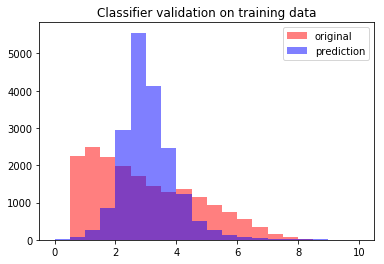

In [66]:
plt.hist(y_valid, bins=20, alpha=.5, color='red', label='original', range=(0,10))
plt.hist(ridge_valid, bins=20, alpha=.5, color='blue', label='prediction', range=(0,10))
plt.legend()
plt.title('Classifier validation on training data')

Caculate MAE for training data set, recall that our target (number of claps) is log1p transformed.

In [57]:
mae_valid = mean_absolute_error(y_valid, ridge_valid)
mae_valid, np.expm1(mae_valid)

(1.30587271708131, 2.6909088077130057)

The prediction for validation is not perfect, but somewhat acceptable. On average, this model yields approximately 2.7 errors in predicting the number of claps. Let's see how it works for predicting the testing dataset.

In [58]:
%%time
ridge.fit(X_train, y_train)

CPU times: user 5min 2s, sys: 4.15 s, total: 5min 6s
Wall time: 5min 15s


Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=2, solver='auto', tol=0.001)

In [60]:
%%time
ridge_pred = ridge.predict(X_test)

CPU times: user 256 ms, sys: 816 ms, total: 1.07 s
Wall time: 1.51 s


In [63]:
def write_submission_file(prediction, filename,
    path_to_sample=os.path.join(PATH_TO_DATA, 'sample_submission.csv')):
    submission = pd.read_csv(path_to_sample, index_col='id')
    submission['log_recommends'] = prediction
    submission.to_csv(filename)

In [64]:
write_submission_file(prediction=ridge_pred, filename='BoW_ridge.csv')

Kaggle gives this submission with MAE approximately 2.12, so this model yields about 2.12 errors in prediction.

### 3. Topic modeling with LDA

Stack sparse matrix from test and train. Transform to gensim corpus.

In [24]:
from scipy import sparse
full_sparse_data =  sparse.vstack([X_train, X_test])

In [25]:
gensim_corpus_data = gensim.matutils.Sparse2Corpus(full_sparse_data, documents_columns=False)

Build a dictionary for the LDA model.

In [40]:
vocabulary_gensim = {}
for key, val in BoW.vocabulary_.items():
    vocabulary_gensim[val] = key
    
dict = Dictionary()
dict.merge_with(vocabulary_gensim)

In [43]:
%%time
lda = LdaModel(gensim_corpus_data, num_topics = 50)

CPU times: user 20min 29s, sys: 17.7 s, total: 20min 47s
Wall time: 11min 19s


In [2]:
import pyLDAvis.gensim
lda_data =  pyLDAvis.gensim.prepare(lda, gensim_corpus_data, dict)

NameError: name 'lda' is not defined

In [ ]:
pyLDAvis.display(lda_data)

**Read train target and split data for validation.**

In [ ]:
train_target = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_log1p_recommends.csv'), 
                           index_col='id')
y_train = train_target['log_recommends'].values

In [ ]:
train_part_size = int(0.7 * train_target.shape[0])
X_train_part_sparse = X_train_sparse[:train_part_size, :]
y_train_part = y_train[:train_part_size]
X_valid_sparse =  X_train_sparse[train_part_size:, :]
y_valid = y_train[train_part_size:]

**Train a simple Ridge model and check MAE on the validation set.**

In [ ]:
# You code here

**Train the same Ridge with all available data, make predictions for the test set and form a submission file.**

In [ ]:
# You code here

In [ ]:
def write_submission_file(prediction, filename,
                          path_to_sample=os.path.join(PATH_TO_DATA, 
                                                      'sample_submission.csv')):
    submission = pd.read_csv(path_to_sample, index_col='id')
    
    submission['log_recommends'] = prediction
    submission.to_csv(filename)

In [ ]:
write_submission_file(ridge_test_pred, os.path.join(PATH_TO_DATA,
                                                    'assignment2_medium_submission.csv'))

**Now's the time for dirty Kaggle hacks. Form a submission file with all zeros. Make a submission. What do you get if you think about it? How is it going to help you with modifying your predictions?**

In [ ]:
write_submission_file(np.zeros_like(ridge_test_pred), 
                      os.path.join(PATH_TO_DATA,
                                   'medium_all_zeros_submission.csv'))